# **DATA PREPROCESSING AND CNN_MLP MODEL ARCHITECTURE**

 **🔹Step 1: Load & Split the Data with spot_id Alignment**

In [3]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb
import random
import pandas as pd
import anndata as ad
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [7]:
del adata

NameError: name 'adata' is not defined

In [5]:

# 🔹 Load Gene Expression Data
IMAGE_PATH = '../dataset/dataset.tsv'  # Update with your path
GENE_EXPRESSION_PATH = '../dataset/cm_final.tsv'  # Update with your path
SPATIAL_COORDINATES_PATH  = '../dataset/spatial_coords_final.tsv'
NUM_CLASSES = 4  # Multiclass prediction (5 disease stages)

# Load histology image metadata (includes 'spot_id', 'img_path', 'label')
df_img = pd.read_csv(IMAGE_PATH, sep="\t")

# Clean the columns
df_img = (df_img.rename(columns={'Unnamed: 0': 'spot_id'})  # Rename first column
           .drop(columns=['cm'])  # Remove cm column
           .set_index('spot_id').astype(str))

# Verify changes
df_img.head()


,img,label
spot_id,,
CN51_C2_2_1.996x25.956,../dataset/tile\CN51_C2_2\CN51_C2_2-1.996-25.9...,p70
CN51_C2_2_2.004x26.954,../dataset/tile\CN51_C2_2\CN51_C2_2-2.004-26.9...,p70
CN51_C2_2_2.006x31.917,../dataset/tile\CN51_C2_2\CN51_C2_2-2.006-31.9...,p70
CN51_C2_2_2.007x29.936,../dataset/tile\CN51_C2_2\CN51_C2_2-2.007-29.9...,p70
CN51_C2_2_2.007x32.938,../dataset/tile\CN51_C2_2\CN51_C2_2-2.007-32.9...,p70


In [7]:
df_sc = pd.read_csv(SPATIAL_COORDINATES_PATH, sep='\t')
df_sc = (df_sc.rename(columns={'Unnamed: 0': 'spot_id'})
         .set_index('spot_id').astype(str))
df_sc.head()

,X,Y
spot_id,,
CN51_C2_2_1.996x25.956,1.996,25.956
CN51_C2_2_2.004x26.954,2.004,26.954
CN51_C2_2_2.006x31.917,2.006,31.917
CN51_C2_2_2.007x29.936,2.007,29.936
CN51_C2_2_2.007x32.938,2.007,32.938


In [9]:

# Load data skipping the first row (numeric headers)
df_cm = pd.read_csv(GENE_EXPRESSION_PATH, sep='\t')

# Rename first column to spot_id and remove metadata columns
df_cm = (
    df_cm.rename(columns={df_cm.columns[0]: 'spot_id'})
    .iloc[:, :-2]  # Remove last two columns (age/breed)
    .set_index('spot_id').astype(str)
)

# Convert all columns to numeric values
df_cm = df_cm.apply(pd.to_numeric, errors='coerce')

# Verify cleaned structure
df_cm.head()


,Fam234a,Nefl,Sema5a,Tom1l2,Nbea,Mif,Pcsk1n,Tsfm,Zfp706,Sfpq,...,__ambiguous.Dnajc19.Dnajc19,__ambiguous.Glcci1.Gm16039,__ambiguous.BC037034.BC037034,__ambiguous.Prrt2.Pagr1a,__ambiguous.Grcc10.Atn1,__ambiguous.RP24-137C19.6.Pmp2,__ambiguous.DHX30.DHX30.Dhx30,__ambiguous.Map4.Map4,Mical3.1,Gm10801
spot_id,,,,,,,,,,,,,,,,,,,,,
CN51_C2_2_1.996x25.956,0.0,0.000000,0.001669,0.0,0.0,0.000835,0.000000,0.000835,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN51_C2_2_2.004x26.954,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN51_C2_2_2.006x31.917,0.0,0.000695,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN51_C2_2_2.007x29.936,0.0,0.001284,0.000000,0.0,0.0,0.000257,0.000514,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CN51_C2_2_2.007x32.938,0.0,0.001478,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **VISUALIZATION**

In [11]:

# Verify index alignment between datasets
assert df_cm.index.equals(df_sc.index), "Gene matrix and spatial coordinates index mismatch!"
assert df_cm.index.equals(df_img.index), "Gene matrix and image metadata index mismatch!"

# Create AnnData object with proper structure
# --------------------------------------------
adata = ad.AnnData(
    X=df_cm.astype(np.float32),  # Ensure gene expression data is float32
    obs=df_sc.join(df_img),  # Merge spatial coordinates and image metadata
)

# Add spatial coordinates to dedicated structure
# -----------------------------------------------
# Extract spatial coordinates using uppercase column names
# Ensure spatial coordinates are stored as float64
adata.obsm["spatial"] = df_sc[["X", "Y"]].astype(np.float64).values
  # Extracting 'X' and 'Y'

# Verify final structure
# ----------------------
print("\n✔️ AnnData object summary:")
print(f"  - Observations (spots): {adata.n_obs}")
print(f"  - Variables (genes): {adata.n_vars}")
print(f"  - Observation metadata: {adata.obs.columns.tolist()}")
print(f"  - Spatial coordinates shape: {adata.obsm['spatial'].shape}")

# Quality control checks
# -----------------------
# Check for missing values
assert not np.isnan(adata.X).any(), "❌ Error: Missing values detected in gene matrix!"
assert not adata.obs.isna().any().any(), "❌ Error: Missing values detected in metadata!"

# Check if image paths exist
missing_images = [img for img in adata.obs['img'] if not Path(img).exists()]
if missing_images:
    print(f"⚠️ Warning: {len(missing_images)} image files are missing! Example paths: {missing_images[:3]}")
else:
    print("✔️ All image files are present!")



✔️ AnnData object summary:
  - Observations (spots): 2114
  - Variables (genes): 11639
  - Observation metadata: ['X', 'Y', 'img', 'label']
  - Spatial coordinates shape: (2114, 2)
✔️ All image files are present!


   ## **NORMALIZATION**

   ---
   The next preprocessing step is normalization. A common approach is **count depth scaling** (Which i have already done in count_matrix.py) with subsequent **log plus one (log1p) transformation**. Count depth scaling normalizes the data to a “size factor” such as the median count depth in the dataset, ten thousand (CP10k) or one million (CPM, counts per million). The size factor for count depth scaling can be controlled via target_sum in pp.normalize_total. We are applying median count depth normalization with log1p transformation (AKA log1PF).

In [13]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

In [15]:
# Logarithmize the data
sc.pp.log1p(adata)
adata.layers["log_normalized"] = adata.X.copy()  # Save log-transformed data

## **FEATURE SELECTION**
---
As a next step, we want to reduce the dimensionality of the dataset and only include the most informative genes. This step is commonly known as feature selection. The scanpy function pp.highly_variable_genes annotates highly variable genes by reproducing the implementations of Seurat [Satija et al., 2015], Cell Ranger [Zheng et al., 2017], and Seurat v3 [Stuart et al., 2019] depending on the chosen flavor.

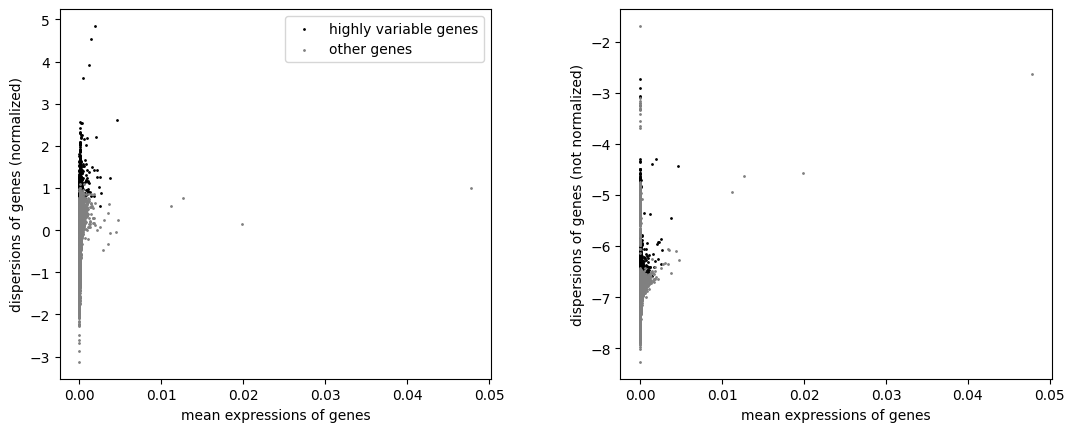

In [18]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000, batch_key="label")
sc.pl.highly_variable_genes(adata)


In [ ]:

# Ensure scaling is only done once
if "scaled" not in adata.layers:  
    adata.layers["scaled"] = adata.X.copy()  # Store raw values before scaling
    sc.pp.scale(adata, zero_center=True)  # Scale the data
    adata.layers["scaled"] = adata.X.copy()  # Store scaled values in a new layer


In [ ]:

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=10)  # Adjust number as needed

# Extract gene names
important_genes = adata.var[adata.var["highly_variable"]].index.tolist()

# Confirm extraction
print(f"✅ Selected {len(important_genes)} highly variable genes.")

sc.pl.heatmap(
    adata, 
    var_names=important_genes, 
    groupby="label", 
    layer="scaled",  # Use the scaled layer
    vmin=-2, vmax=2, 
    figsize=(11, 12)
)


### **🔍 Interpretation of the Heatmap with Respect to Disease Stages and Genes**
Your heatmap shows **gene expression patterns** across different **disease stages (`p30`, `p70`, `p100`, `p120`)** for a selected set of genes. Let’s break down the key insights.

---

## **1️⃣ Understanding the Heatmap Structure**
- **Rows (`p30`, `p70`, `p100`, `p120`)** → Represent different **disease stages**.
- **Columns (genes: Mag, Ubc, Nefap2, etc.)** → Represent the **top differentially expressed genes**.
- **Color Scale**:
  - **Yellow/Green (+ values)** → Higher expression (upregulated genes).
  - **Blue/Purple (- values)** → Lower expression (downregulated genes).

---

## **2️⃣ Key Observations from the Heatmap**
### 🔹 **Genes That Are Highly Expressed in Early Stages (`p30`)**
- Genes like **"Mag" and "Ubc"** show **higher expression (yellow/green) in `p30`**.
- This suggests that **these genes may play an important role in the early stage of the disease**.
- **Possible Interpretation**: These genes could be **early-stage biomarkers**, indicating an **initial immune response or cellular activation**.

### 🔹 **Genes That Increase in Late Stages (`p100`, `p120`)**
- **"Timp2" and "Bgn"** seem **upregulated in `p100` and `p120`**, but not in `p30` or `p70`.
- **Possible Interpretation**: These genes might be **late-stage biomarkers** involved in **tissue remodeling, fibrosis, or chronic inflammation**.

### 🔹 **Genes That Show Gradual Increase from `p30` to `p120`**
- Some genes (**"Kif1a", "TmcC2", "Epbl11"**) show a **gradual increase in expression across all stages**.
- **Possible Interpretation**: These genes may be linked to **disease progression** and **could indicate worsening pathology over time**.

### 🔹 **Genes That Are Consistently Expressed Across All Stages**
- Some genes remain **blue (low expression) or neutral across all disease stages**.
- **Possible Interpretation**: These genes might be **housekeeping genes** or **not strongly associated with disease progression**.

---

## **3️⃣ Biological Interpretation & Hypotheses**
### **✔ What This Means for Disease Progression**
- **Early-stage genes (`p30`)** → Likely involved in **early response to disease**, possibly inflammation or immune activation.
- **Mid-stage genes (`p70`, `p100`)** → May reflect **transitional cellular changes** or **progressive tissue damage**.
- **Late-stage genes (`p120`)** → Might be involved in **chronic fibrosis, neuronal loss, or tissue remodeling**.

### **✔ Potential Clinical Application**
- **Upregulated genes in `p30` (e.g., "Mag", "Ubc")** → Could be used as **early diagnostic biomarkers**.
- **Genes that increase in `p100` and `p120` (e.g., "Timp2", "Bgn")** → May serve as **targets for therapeutic intervention**.
- **Gradually increasing genes (e.g., "Kif1a", "TmcC2")** → Could help in **predicting disease severity over time**.


## **Dimensionality Reduction**


In [20]:
# Restore log_normalized counts to avoid generating genes with negative expression due to scaling
adata.X = adata.layers["log_normalized"].copy()

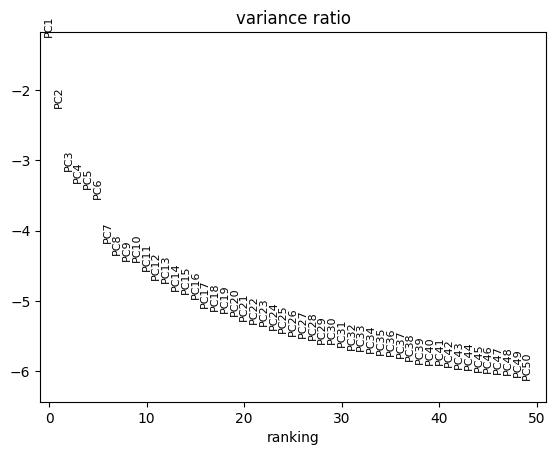

In [22]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

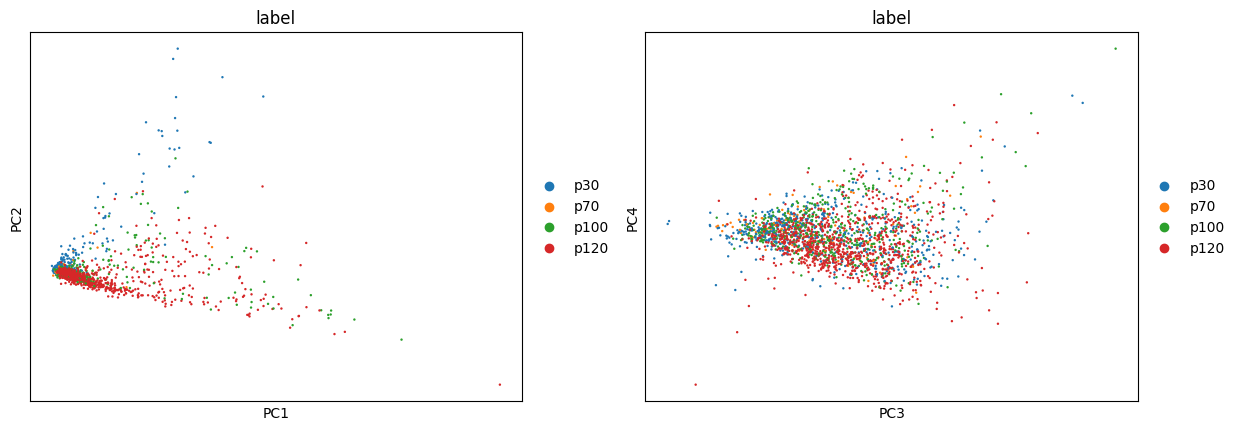

In [24]:
sc.pl.pca(
    adata,
    color=["label", "label"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=12  # Increase marker size
)


Your **PCA plot** provides a way to **visualize variance in gene expression** across different disease stages (`p30, p70, p100, p120`).

### **🔍 Interpretation of the PCA Plot**
1️⃣ **PC1 vs PC2 (Left Plot)**  
   - Shows that **p30 (blue) and p120 (red) are more dispersed**, indicating high variance in gene expression.  
   - **p100 (green) and p70 (orange) overlap more**, suggesting similarity in gene expression.  

2️⃣ **PC3 vs PC4 (Right Plot)**  
   - Shows **p30 clustering tightly** at one end, meaning its gene expression pattern is more distinct.  
   - **p120 and p100 are more spread out**, which could mean gradual progression in gene expression changes.

### **✅ Key Points**
✔ **p30 is the most distinct stage** in terms of gene expression.  
✔ **p70 and p100 share similarities**, but some separation occurs.  
✔ **p120 is highly variable**, possibly indicating late-stage differentiation.  


## **Nearest neighbor graph constuction and visualization**

C:\Users\olanr\anaconda3\envs\pvt_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\olanr\anaconda3\envs\pvt_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\olanr\anaconda3\envs\pvt_env\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\olanr\anaconda3\envs\pvt_env\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\olanr\anaconda3\envs\pvt_env\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess

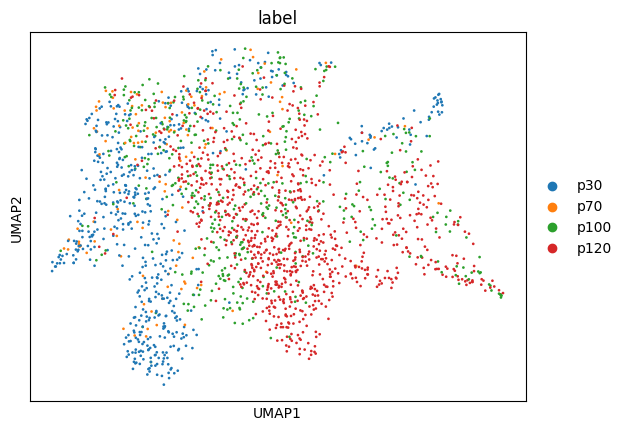

In [28]:

sc.pp.neighbors(adata, n_neighbors=15)  # Recompute graph
sc.tl.umap(adata, min_dist=0.5, random_state=42)  # Use a fixed seed for stability
sc.pl.umap(adata, color="label", size=15)  # Plot again



## **✅ Key Observations**
### **1️⃣ Clear Clustering of Disease Stages**
   - **p30 (Blue)** is **more concentrated** in the **lower-left region**, suggesting a distinct expression profile.
   - **p70 (Orange)** appears **moderately spread**, potentially indicating an **intermediate stage**.
   - **p100 (Green) & p120 (Red)** dominate the **upper and right regions**, possibly reflecting later disease stages.

---

### **2️⃣ Smooth Transition Between Stages**
   - The **gradual spread of colors** supports a **progressive change in gene expression** across stages.
   - **Overlap between p100 (Green) & p120 (Red)** might suggest **biological similarities**, or could be due to **shared gene expression patterns**.

---

### **3️⃣ Potential Biomarkers for Classification**
   - Genes contributing to these **separations** can serve as **biomarkers** for classification.
   - **Differential gene expression (DGE) analysis** between clusters can highlight key regulatory genes.
   - **Machine learning models (e.g., logistic regression, random forest)** can classify new samples based on gene expression.


# **DIFFERENCIAL EXPRESSION ANALYSIS (Using Logistic Regression-Based)**


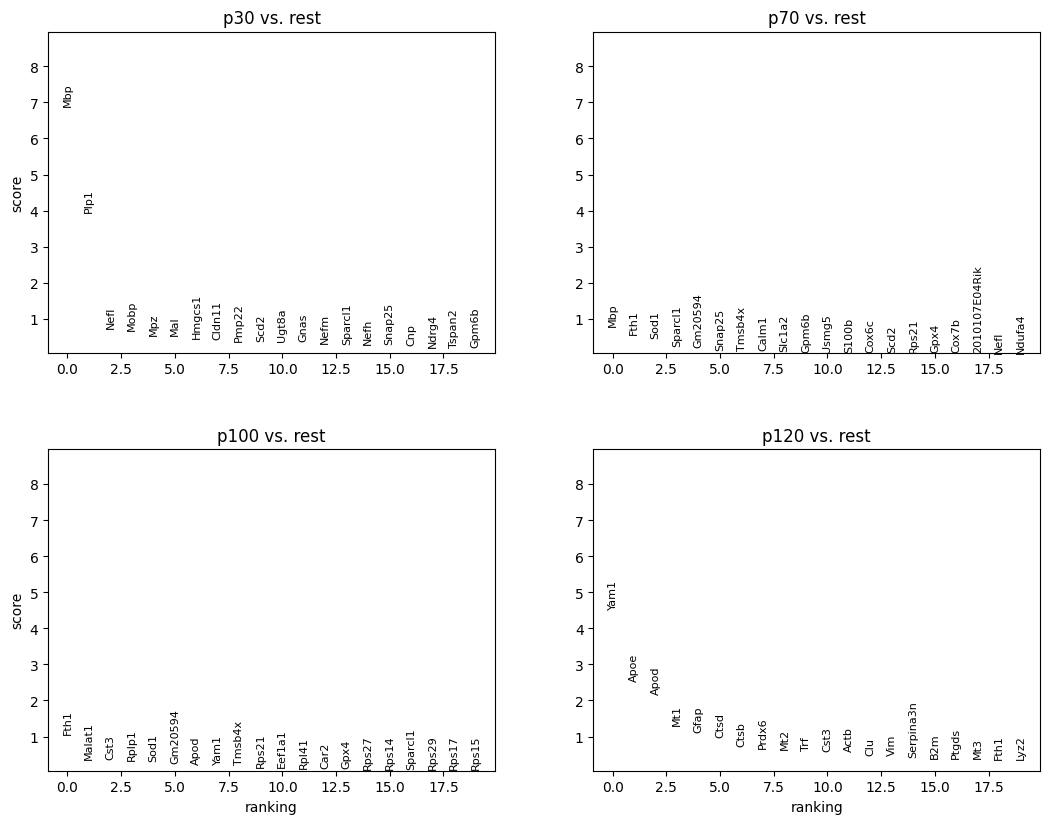

In [30]:
sc.tl.rank_genes_groups(adata, groupby="label", method="logreg")  # Logistic regression-based DE

# Plot with two columns for better visualization
sc.pl.rank_genes_groups(adata, ncols=2)  # Splits into 2 columns



### **🔍 Key Insights from Your Plot**

#### **1️⃣ Genes That Define Each Disease Stage**
- The **higher-ranked genes** (leftmost in each plot) are the **best markers** for that stage.
- **Example:** Genes like **"Nap"** and **"Rpl1"** are **strong markers for `p30`**.
- Different genes dominate each disease stage, indicating **distinct molecular changes** as the disease progresses.

#### **2️⃣ Potential Biomarkers for Classification**
- The **highest-ranked genes** (top-scoring) can serve as **biomarkers** for diagnosing different **disease stages**.
- These genes can be used to **train a classifier** (e.g., **Random Forest, SVM**) to predict **disease stage based on gene expression**.

In [32]:
import os
import numpy as np
import scanpy as sc
from PIL import Image

# Initialize spatial dictionary
adata.uns["spatial"] = {}

# Iterate over each unique image in the dataset
unique_images = adata.obs["img"].unique()

for img_path in unique_images:
    if os.path.exists(img_path):  # Check if file exists
        image = Image.open(img_path)
        image_array = np.array(image)

        # Store image in adata.uns["spatial"]
        adata.uns["spatial"][img_path] = {"hires": {"images": image_array}}
    else:
        print(f"⚠️ Warning: Image not found for {img_path}")


In [33]:
import os
import numpy as np
import scanpy as sc
from PIL import Image

# Initialize spatial dictionary if not already present
if "spatial" not in adata.uns:
    adata.uns["spatial"] = {}

# Iterate over each unique image in the dataset
unique_images = adata.obs["img"].unique()

for img_path in unique_images:
    if os.path.exists(img_path):  # Check if file exists
        image = Image.open(img_path)
        image_array = np.array(image)

        # Extract Library ID (Modify this based on your file structure)
        library_id = os.path.basename(os.path.dirname(img_path))  # Extract folder name as ID

        # Ensure the library ID exists in the spatial dictionary
        if library_id not in adata.uns["spatial"]:
            adata.uns["spatial"][library_id] = {
                "images": {},
                "scalefactors": {"tissue_hires_scalef": 1.0},  # Set default scale factor
                "metadata": {}
            }

        # Store the image in the correct location
        adata.uns["spatial"][library_id]["images"]["hires"] = image_array

    else:
        print(f"⚠️ Warning: Image not found for {img_path}")

print("✅ Spatial images successfully added to adata!")


✅ Spatial images successfully added to adata!


# **PREPARING THE DATA FOR TRAINING**

## **Selecting the Best Features**

In [36]:

# Rank genes using logistic regression
sc.tl.rank_genes_groups(adata, groupby="label", method="logreg")

# Extract top-ranked genes from all groups, ensuring uniqueness
top_logreg_genes = (
    pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
    .stack()  # Convert wide format to long format
    .unique()  # Keep only unique genes
)[:1000]  # Select top 1000 unique genes

# Ensure top_logreg_genes is a list
top_logreg_genes = list(top_logreg_genes)

# Create DataFrame with selected features
df_logreg = pd.DataFrame(
    adata[:, top_logreg_genes].X.A if hasattr(adata[:, top_logreg_genes].X, "A") else adata[:, top_logreg_genes].X,
    columns=top_logreg_genes,
    index=adata.obs.index
)

# Display the first 5 rows
df_logreg.head()


,Mbp,Fth1,Yam1,Plp1,Malat1,Apoe,Nefl,Sod1,Cst3,Apod,...,Cx3cr1,Srp9,Nrsn2,Cdh2,Thra,Ptprd,Ddx3y,Fam57b,Ttbk2,Ndufa7
spot_id,,,,,,,,,,,,,,,,,,,,,
CN51_C2_2_1.996x25.956,0.042490,0.031227,0.0,0.025547,0.005826,0.004165,0.000000,0.012443,0.006656,0.007484,...,0.0,0.0,0.0,0.0,0.0,0.001668,0.0,0.000000,0.000000,0.0
CN51_C2_2_2.004x26.954,0.043514,0.052505,0.0,0.021334,0.002692,0.002692,0.000000,0.012056,0.010724,0.001347,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.001347,0.001347,0.0
CN51_C2_2_2.006x31.917,0.050841,0.034180,0.0,0.018602,0.012440,0.002778,0.000695,0.002084,0.000695,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.002084,0.0,0.000000,0.000000,0.0
CN51_C2_2_2.007x29.936,0.005889,0.004100,0.0,0.004356,0.003845,0.000770,0.001283,0.014025,0.002052,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000257,0.000000,0.0
CN51_C2_2_2.007x32.938,0.065785,0.049740,0.0,0.028417,0.010294,0.001477,0.001477,0.012486,0.000000,0.002215,...,0.0,0.0,0.0,0.0,0.0,0.002215,0.0,0.000000,0.000000,0.0


In [38]:
# Ensure spot_id is a column in all dataframes
df_img = df_img.reset_index()  
df_sc = df_sc.reset_index()    
df_logreg = df_logreg.reset_index()

Class distribution:
 label
p120    922
p30     572
p100    488
p70     132
Name: count, dtype: int64


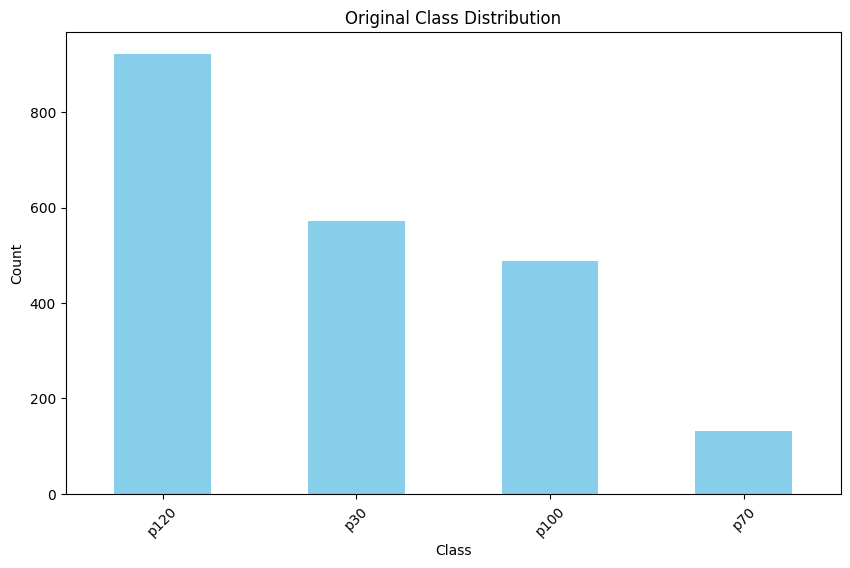

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Merge datasets using spot_id as the key
combined_df = pd.merge(
    pd.merge(
        df_img[['spot_id', 'img', 'label']],
        df_logreg,
        on='spot_id'
    ),
    df_sc,
    on='spot_id',
    how='inner'
)

COMBINED_PATH = '../dataset/combined_df.tsv'  # Update with your path
# Save the DataFrame as a TSV file
combined_df.to_csv(COMBINED_PATH, sep='\t', index=False)

# Verify class distribution
print("Class distribution:\n", combined_df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10,6))
combined_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [51]:
combined_df.head()

,spot_id,img,label,Mbp,Fth1,Yam1,Plp1,Malat1,Apoe,Nefl,...,Nrsn2,Cdh2,Thra,Ptprd,Ddx3y,Fam57b,Ttbk2,Ndufa7,X,Y
0,CN51_C2_2_1.996x25.956,../dataset/tile\CN51_C2_2\CN51_C2_2-1.996-25.9...,p70,0.042490,0.031227,0.0,0.025547,0.005826,0.004165,0.000000,...,0.0,0.0,0.0,0.001668,0.0,0.000000,0.000000,0.0,1.996,25.956
1,CN51_C2_2_2.004x26.954,../dataset/tile\CN51_C2_2\CN51_C2_2-2.004-26.9...,p70,0.043514,0.052505,0.0,0.021334,0.002692,0.002692,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.001347,0.001347,0.0,2.004,26.954
2,CN51_C2_2_2.006x31.917,../dataset/tile\CN51_C2_2\CN51_C2_2-2.006-31.9...,p70,0.050841,0.034180,0.0,0.018602,0.012440,0.002778,0.000695,...,0.0,0.0,0.0,0.002084,0.0,0.000000,0.000000,0.0,2.006,31.917
3,CN51_C2_2_2.007x29.936,../dataset/tile\CN51_C2_2\CN51_C2_2-2.007-29.9...,p70,0.005889,0.004100,0.0,0.004356,0.003845,0.000770,0.001283,...,0.0,0.0,0.0,0.000000,0.0,0.000257,0.000000,0.0,2.007,29.936
4,CN51_C2_2_2.007x32.938,../dataset/tile\CN51_C2_2\CN51_C2_2-2.007-32.9...,p70,0.065785,0.049740,0.0,0.028417,0.010294,0.001477,0.001477,...,0.0,0.0,0.0,0.002215,0.0,0.000000,0.000000,0.0,2.007,32.938


# *Multimodal Data Generator*

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode labels ONCE for all data
label_encoder = LabelEncoder()
combined_df['label_encoded'] = label_encoder.fit_transform(combined_df['label'])

# Stratified split using encoded labels
train_df, test_df = train_test_split(combined_df, test_size=0.2, stratify=combined_df['label_encoded'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label_encoded'], random_state=42)

# ✅ Print label distributions
print("Train Labels:\n", train_df['label'].value_counts())
print("Validation Labels:\n", val_df['label'].value_counts())
print("Test Labels:\n", test_df['label'].value_counts())


Train Labels:
 label
p120    589
p30     366
p100    312
p70      85
Name: count, dtype: int64
Validation Labels:
 label
p120    148
p30      92
p100     78
p70      21
Name: count, dtype: int64
Test Labels:
 label
p120    185
p30     114
p100     98
p70      26
Name: count, dtype: int64


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

class MultimodalDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, label_encoder, batch_size=32, img_size=(299, 299), num_classes=4, shuffle=True):
        self.df = dataframe.copy()
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.label_encoder = label_encoder
        self.indexes = np.arange(len(self.df))
        self.df['label_encoded'] = self.label_encoder.transform(self.df['label'])
        
        # Image augmentation configuration
        self.img_datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=lambda x: x/255.0  # Built-in normalization
        )
        
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        # Gene expression features (first input)
        cm_features = batch_df.drop(
            columns=['spot_id', 'img', 'label', 'label_encoded', 'X', 'Y']
        ).values.astype('float32')
        
        # Validate count matrix shape
        if cm_features.shape[1] != 1000:
            raise ValueError(f"Invalid count matrix shape: {cm_features.shape[1]} features (expected 1000)")

        # Image loading and augmentation (second input)
        images = np.array([self.safe_load_img(row['img']) for _, row in batch_df.iterrows()])
        images = self.img_datagen.flow(
            images, 
            batch_size=self.batch_size,
            shuffle=False
        ).next()

        # Labels
        batch_labels = batch_df['label_encoded'].values
        labels = to_categorical(batch_labels, num_classes=self.num_classes)

        # Return in correct order: (gene_features, images), labels
        return (
            (
                tf.convert_to_tensor(cm_features, dtype=tf.float32),  # Gene input
                tf.convert_to_tensor(images, dtype=tf.float32)       # Image input
            ),
            tf.convert_to_tensor(labels, dtype=tf.float32)
        )

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def safe_load_img(self, path):
        """Robust image loading with error handling"""
        try:
            img = load_img(path, color_mode='rgb', target_size=self.img_size)
            return img_to_array(img)
        except Exception as e:
            print(f"Error loading image {path}: {str(e)}")
            # Return blank image with proper dimensions
            return np.zeros((*self.img_size, 3), dtype=np.float32)

In [46]:
train_gen = MultimodalDataGenerator(train_df, label_encoder=label_encoder, batch_size=32, num_classes=4)
val_gen = MultimodalDataGenerator(val_df, label_encoder=label_encoder, batch_size=32, num_classes=4)
test_gen = MultimodalDataGenerator(test_df, label_encoder=label_encoder, batch_size=32, num_classes=4)

In [48]:
train_df.head()

,spot_id,img,label,Mbp,Fth1,Yam1,Plp1,Malat1,Apoe,Nefl,...,Cdh2,Thra,Ptprd,Ddx3y,Fam57b,Ttbk2,Ndufa7,X,Y,label_encoded
1509,L7CN84_E1_12.945x26.93,../dataset/tile\L7CN84_E1\L7CN84_E1-12.945-26....,p100,0.012270,0.010236,0.046239,0.016327,0.006154,0.012270,0.002055,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.945,26.93,0
719,CN81_E1_10.94x6.89,../dataset/tile\CN81_E1\CN81_E1-10.94-6.89.jpeg,p30,0.014245,0.007593,0.012254,0.013803,0.000448,0.002686,0.002463,...,0.000224,0.000896,0.000224,0.000000,0.000000,0.000224,0.000000,10.94,6.89,2
1852,L7CN85_E1_15.954x23.038,../dataset/tile\L7CN85_E1\L7CN85_E1-15.954-23....,p120,0.010909,0.009099,0.018116,0.016319,0.000000,0.005469,0.000000,...,0.001826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.954,23.038,1
1648,L7CN84_E1_27.907x20.91,../dataset/tile\L7CN84_E1\L7CN84_E1-27.907-20....,p100,0.005381,0.008953,0.071986,0.016057,0.004486,0.001797,0.000899,...,0.000000,0.000000,0.000000,0.000899,0.000000,0.000000,0.000899,27.907,20.91,0
1376,CN94_D2_5.88x9.96,../dataset/tile\CN94_D2\CN94_D2-5.88-9.96.jpeg,p120,0.003556,0.005551,0.047188,0.005551,0.002002,0.008647,0.001780,...,0.000000,0.000445,0.000223,0.000000,0.000223,0.000223,0.000000,5.88,9.96,1


In [120]:
# Get one batch
try:
    (gene_batch, img_batch), label_batch = next(iter(train_gen))
    
    print("Gene batch:")
    print(f"- Shape: {gene_batch.shape}")  # Should match (32, 1000)
    print(f"- Dtype: {gene_batch.dtype}")
    print(f"- Min: {tf.reduce_min(gene_batch):.2f}, Max: {tf.reduce_max(gene_batch):.2f}")
    
    print("\nImage batch:")
    print(f"- Shape: {img_batch.shape}")   # Should match (32, 299, 299, 3)
    print(f"- Dtype: {img_batch.dtype}")
    print(f"- Min: {tf.reduce_min(img_batch):.2f}, Max: {tf.reduce_max(img_batch):.2f}")
    
    print("\nLabels:")
    print(f"- Shape: {label_batch.shape}")  # Should match (32, 4)
    print(f"- Example: {label_batch[0]}")

except Exception as e:
    print(f"Error checking generator: {str(e)}")

Gene batch:
- Shape: (32, 1000)
- Dtype: <dtype: 'float32'>
- Min: 0.00, Max: 0.22

Image batch:
- Shape: (32, 299, 299, 3)
- Dtype: <dtype: 'float32'>
- Min: 0.00, Max: 1.00

Labels:
- Shape: (32, 4)
- Example: [0. 0. 1. 0.]


# 🧪 Model Architecture

In [95]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

class CrossAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads=4, dropout_rate=0.1):
        super().__init__()
        self.g2i_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.i2g_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)
        self.gene_ffn = tf.keras.Sequential([
            layers.Dense(embed_dim * 2, activation='gelu'),
            layers.Dense(embed_dim)
        ])
        self.img_ffn = tf.keras.Sequential([
            layers.Dense(embed_dim * 2, activation='gelu'),
            layers.Dense(embed_dim)
        ])
        self.dropout = layers.Dropout(dropout_rate)
        self.norm_gene1 = layers.LayerNormalization()
        self.norm_gene2 = layers.LayerNormalization()
        self.norm_img1 = layers.LayerNormalization()
        self.norm_img2 = layers.LayerNormalization()

    def call(self, gene, image, training=False):
        # Cross-attention
        g2i = self.g2i_attn(gene, image, image, training=training)
        gene_out = self.norm_gene1(gene + self.dropout(g2i, training=training))

        i2g = self.i2g_attn(image, gene, gene, training=training)
        img_out = self.norm_img1(image + self.dropout(i2g, training=training))

        # Feed-forward + residual
        gene_ffn = self.gene_ffn(gene_out)
        gene_final = self.norm_gene2(gene_out + self.dropout(gene_ffn, training=training))

        img_ffn = self.img_ffn(img_out)
        img_final = self.norm_img2(img_out + self.dropout(img_ffn, training=training))

        return gene_final, img_final



# Build Model
def build_improved_cross_attention_model(input_shape_gene, input_shape_img, num_classes):
    input_gene = layers.Input(shape=input_shape_gene, name='gene_input')
    x_gene = layers.Dense(1024, activation='gelu')(input_gene)
    x_gene = layers.LayerNormalization()(x_gene)
    x_gene = layers.Dropout(0.3)(x_gene)
    x_gene = layers.Dense(256, activation='gelu')(x_gene)

    input_img = layers.Input(shape=input_shape_img, name='img_input')
    resized_img = layers.Resizing(299, 299)(input_img)

    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=resized_img, pooling='avg')

    # 🧠 Unfreeze more layers for deeper fine-tuning
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    x_img = base_model.output
    x_img = layers.Dense(512, activation='gelu')(x_img)
    x_img = layers.LayerNormalization()(x_img)
    x_img = layers.Dropout(0.3)(x_img)
    x_img = layers.Dense(256, activation='gelu')(x_img)

    gene_seq = layers.Reshape((1, 256))(x_gene)
    img_seq = layers.Reshape((1, 256))(x_img)

    # 🔁 Stack 2 Cross-Attention blocks
    for _ in range(2):
        gene_seq, img_seq = CrossAttentionBlock(embed_dim=256)(gene_seq, img_seq)

    sequence = layers.Concatenate(axis=1)([gene_seq, img_seq])
    x = layers.MultiHeadAttention(num_heads=4, key_dim=256)(sequence, sequence)
    x = layers.LayerNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='gelu')(x)
    x = layers.Dropout(0.4)(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model3 = models.Model(inputs=[input_gene, input_img], outputs=output)
    return model3



In [97]:
initial_lr = 1e-4
decay_steps = len(train_gen) * 50  # total training steps

# Keep the scheduler, but apply it via a callback instead
cosine_lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    alpha=1e-6
)

optimizer = Adam()  # ← use default for now

# Add as a callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: float(cosine_lr_schedule(epoch * len(train_gen))), verbose=1)


# 🧪 Compile & Train

In [99]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

model3 = build_improved_model(
    input_shape_gene=(1000,), input_shape_img=(None, None, 3), num_classes=4
)

model3.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
    metrics=['accuracy']
)



# Assuming 'train_df' and 'label_encoder' are defined
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label_encoded']),
    y=train_df['label_encoded']
)
class_weight_dict = dict(enumerate(class_weights))


callbacks = [
    lr_callback,
    tf.keras.callbacks.EarlyStopping(patience=8, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
]


history = model3.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
43/43 [==============================] - 79s 2s/step - loss: 1.4080 - accuracy: 0.3543 - val_loss: 1.3911 - val_accuracy: 0.3481 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.990133548853919e-05.
Epoch 2/50
43/43 [==============================] - 75s 2s/step - loss: 1.1271 - accuracy: 0.4919 - val_loss: 1.2051 - val_accuracy: 0.4012 - lr: 9.9901e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.960573515854776e-05.
Epoch 3/50
43/43 [==============================] - 76s 2s/step - loss: 0.9546 - accuracy: 0.5814 - val_loss: 0.6199 - val_accuracy: 0.7994 - lr: 9.9606e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.911435336107388e-05.
Epoch 4/50
43/43 [==============================] - 76s 2s/step - loss: 0.7104 - accuracy: 0.7130 - val_loss: 0.5113 - val_accuracy: 0.8024 - lr: 9.9114e-05

Epoch 5: LearningRateScheduler setting learning rat

# 🧪 Model Evauation 

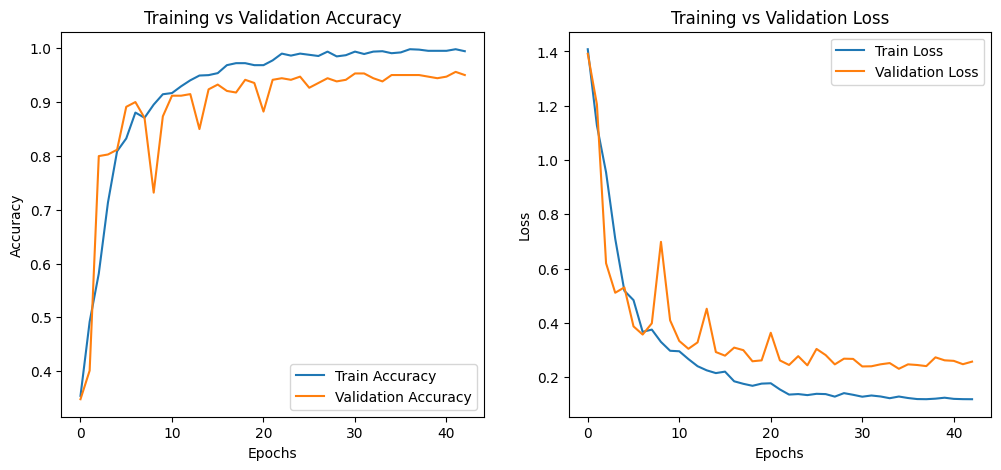

In [101]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


In [107]:
test_results = model.evaluate(test_gen)
print(f"✅ Test Loss: {test_results[0]:.4f}")
print(f"✅ Test Accuracy: {test_results[1]:.4f}")

14/14 [==============================] - 17s 1s/step - loss: 0.2849 - accuracy: 0.9338
✅ Test Loss: 0.2849
✅ Test Accuracy: 0.9338


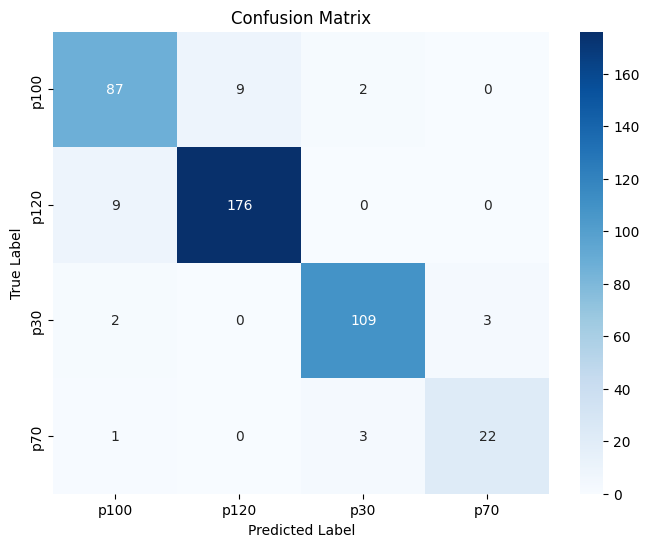

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_true = []
y_pred = []

for i in range(len(test_gen)):
    X, y = test_gen[i]
    preds = model3.predict(X, verbose=0)
    y_pred.extend(preds.argmax(axis=1))
    y_true.extend(y.numpy().argmax(axis=1))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Use class labels from LabelEncoder
class_labels = label_encoder.classes_

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

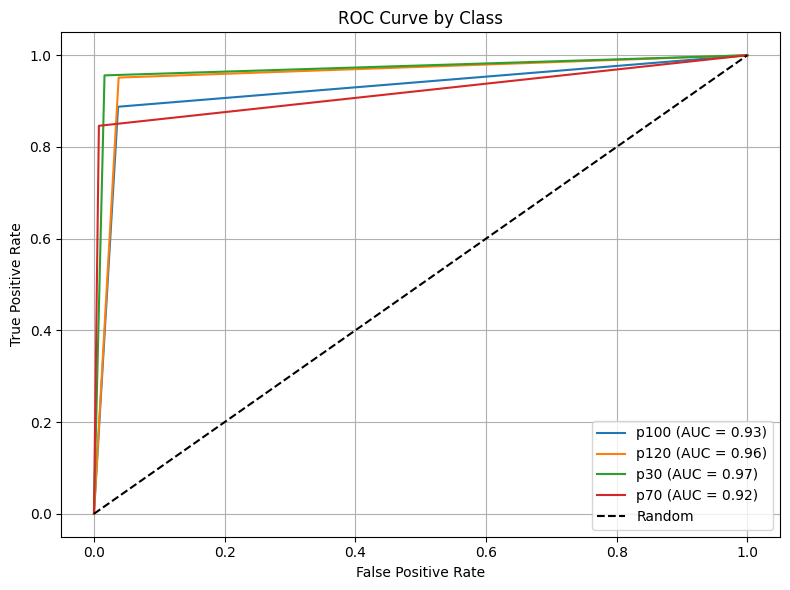


✅ Weighted Average AUC: 0.9508


In [122]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Class labels in label encoder order
class_labels = label_encoder.classes_
num_classes = len(class_labels)

# ✅ Convert to one-hot
y_true_one_hot = to_categorical(y_true, num_classes=num_classes)
y_pred_one_hot = to_categorical(y_pred, num_classes=num_classes)

# ✅ Count true samples per class
class_counts = np.sum(y_true_one_hot, axis=0)

# === Plot ROC & Calculate AUC ===
plt.figure(figsize=(8, 6))
AUCs = []

for i, class_name in enumerate(class_labels):
    if class_counts[i] == 0:
        print(f"⚠️ Skipping {class_name} - No true samples.")
        AUCs.append(0)
        continue

    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_one_hot[:, i])
    auc_score = auc(fpr, tpr)
    AUCs.append(auc_score)

    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Random")

# Finalize plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve by Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Weighted Average AUC
total_samples = np.sum(class_counts)
weighted_AUC = np.sum([AUCs[i] * class_counts[i] for i in range(num_classes)]) / total_samples

print(f"\n✅ Weighted Average AUC: {weighted_AUC:.4f}")


In [124]:
# Compute classification metrics
from sklearn.metrics import classification_report, accuracy_score

report = classification_report(y_true, y_pred, target_names=class_labels)
accuracy = accuracy_score(y_true, y_pred)

# Display results
print("Classification Report:\n", report)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
               precision    recall  f1-score   support

        p100       0.88      0.89      0.88        98
        p120       0.95      0.95      0.95       185
         p30       0.96      0.96      0.96       114
         p70       0.88      0.85      0.86        26

    accuracy                           0.93       423
   macro avg       0.92      0.91      0.91       423
weighted avg       0.93      0.93      0.93       423

Accuracy: 0.93


In [126]:
from sklearn.metrics import confusion_matrix
import numpy as np

# ✅ Use class labels from LabelEncoder
class_labels = label_encoder.classes_
n_classes = len(class_labels)

# ✅ Get class counts based on y_true
class_counts = [np.sum(np.array(y_true) == i) for i in range(n_classes)]

# ✅ Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Initialize TPR and TNR lists
TPR = []  # Sensitivity
TNR = []  # Specificity

# ✅ Compute TPR and TNR for each class
for i, class_name in enumerate(class_labels):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)

    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) != 0 else 0

    TPR.append(tpr)
    TNR.append(tnr)

    print(f"Class {class_name} - TPR (Sensitivity): {tpr:.2f}, TNR (Specificity): {tnr:.2f}")

# ✅ Compute weighted averages
total_samples = np.sum(class_counts)
weighted_TPR = np.sum([TPR[i] * class_counts[i] for i in range(n_classes)]) / total_samples
weighted_TNR = np.sum([TNR[i] * class_counts[i] for i in range(n_classes)]) / total_samples

# ✅ Display results
print(f"\n✅ Weighted Average TPR (Sensitivity): {weighted_TPR:.2f}")
print(f"✅ Weighted Average TNR (Specificity): {weighted_TNR:.2f}")


Class p100 - TPR (Sensitivity): 0.89, TNR (Specificity): 0.96
Class p120 - TPR (Sensitivity): 0.95, TNR (Specificity): 0.96
Class p30 - TPR (Sensitivity): 0.96, TNR (Specificity): 0.98
Class p70 - TPR (Sensitivity): 0.85, TNR (Specificity): 0.99

✅ Weighted Average TPR (Sensitivity): 0.93
✅ Weighted Average TNR (Specificity): 0.97


In [3]:
import numpy as np
from sklearn.metrics import cohen_kappa_score, mean_absolute_error, mean_squared_error

# Confusion matrix for Hybrid CNN–MLP (Image + Gene model)
conf_matrix_cnn_mlp = np.array([
    [87, 9, 2, 0],     # True p100 (0)
    [9, 176, 0, 0],    # True p120 (1)
    [2, 0, 109, 3],    # True p30  (2)
    [1, 0, 3, 22]      # True p70  (3)
])

# Generate true and predicted label lists
true_labels_cnn_mlp = []
pred_labels_cnn_mlp = []

for true_class in range(conf_matrix_cnn_mlp.shape[0]):
    for pred_class in range(conf_matrix_cnn_mlp.shape[1]):
        count = conf_matrix_cnn_mlp[true_class, pred_class]
        true_labels_cnn_mlp.extend([true_class] * count)
        pred_labels_cnn_mlp.extend([pred_class] * count)

# Calculate metrics
kappa_cnn_mlp = cohen_kappa_score(true_labels_cnn_mlp, pred_labels_cnn_mlp)
mae_cnn_mlp = mean_absolute_error(true_labels_cnn_mlp, pred_labels_cnn_mlp)
rmse_cnn_mlp = np.sqrt (mean_squared_error(true_labels_cnn_mlp, pred_labels_cnn_mlp))


# Relative errors
mean_true_cnn_mlp = np.mean(true_labels_cnn_mlp)
rae_cnn_mlp = np.sum(np.abs(np.array(true_labels_cnn_mlp) - np.array(pred_labels_cnn_mlp))) / np.sum(np.abs(np.array(true_labels_cnn_mlp) - mean_true_cnn_mlp))
rrse_cnn_mlp = np.sqrt(np.sum((np.array(true_labels_cnn_mlp) - np.array(pred_labels_cnn_mlp))**2) / np.sum((np.array(true_labels_cnn_mlp) - mean_true_cnn_mlp)**2))

metrics={
    "Correctly classified": np.trace(conf_matrix_cnn_mlp),
    "Incorrectly classified": np.sum(conf_matrix_cnn_mlp) - np.trace(conf_matrix_cnn_mlp),
    "Total instances": np.sum(conf_matrix_cnn_mlp),
    "Kappa statistic": round(kappa_cnn_mlp, 4),
    "Mean Absolute Error": round(mae_cnn_mlp, 4),
    "Root Mean Squared Error": round(rmse_cnn_mlp, 4),
    "Relative Absolute Error (%)": round(rae_cnn_mlp * 100, 2),
    "Root Relative Squared Error (%)": round(rrse_cnn_mlp * 100, 2)
}

# Convert to plain Python types
clean_metrics = {k: float(v) if isinstance(v, (np.float32, np.float64)) else int(v) for k, v in metrics.items()}

print(clean_metrics)

{'Correctly classified': 394, 'Incorrectly classified': 29, 'Total instances': 423, 'Kappa statistic': 0.8989, 'Mean Absolute Error': 0.0827, 'Root Mean Squared Error': 0.3404, 'Relative Absolute Error (%)': 12.2, 'Root Relative Squared Error (%)': 40.08}
